# **Speech emotion recognition** 

In this experiment, I attempted to recognize emotions in short voice messages (less than 3 seconds). I will use four datasets containing English phrases voiced by professional actors: RAVDESS, CREMA-D, SAVEE, and TESS.

Datasets used in this project contains ~7 types of main emotions: Happy, Fear, Angry, Disgust, Surprised, Sad or Neutral.

# ***Importing libraries***

In [1]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio

from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools

2024-07-09 23:16:30.977300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 23:16:30.977441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 23:16:31.158599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths to
Ravdess = "../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "../input/speech-emotion-recognition-en/Crema"
Savee = "../input/speech-emotion-recognition-en/Savee"
Tess = "../input/speech-emotion-recognition-en/Tess"

# ***Ravdess dataset***

Ravdess:

Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


So, here's an example of an audio filename. 02-01-06-01-02-01-12.wav This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

In [4]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [5]:
Ravdess_df['Emotion'] = Ravdess_df['Emotion'].replace({
    1: 'neutral',
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
})
Ravdess_df.head()

Emotion                                               Path
0  surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   neutral  ../input/speech-emotion-recognition-en/Ravdess...

# ***Crema dataset***

The third component is responsible for the emotion label:

* SAD - sadness;
* ANG - angry;
* DIS - disgust;
* FEA - fear;
* HAP - happy;
* NEU - neutral.

In [6]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))

Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

Emotion                                               Path
0  disgust  ../input/speech-emotion-recognition-en/Crema/1...
1    happy  ../input/speech-emotion-recognition-en/Crema/1...
2    happy  ../input/speech-emotion-recognition-en/Crema/1...
3  disgust  ../input/speech-emotion-recognition-en/Crema/1...
4  disgust  ../input/speech-emotion-recognition-en/Crema/1...

# ***TESS dataset***

Very similar to Crema - label of emotion is contained in the name of file.

In [7]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

Emotion                                               Path
0    fear  ../input/speech-emotion-recognition-en/Tess/YA...
1    fear  ../input/speech-emotion-recognition-en/Tess/YA...
2    fear  ../input/speech-emotion-recognition-en/Tess/YA...
3    fear  ../input/speech-emotion-recognition-en/Tess/YA...
4    fear  ../input/speech-emotion-recognition-en/Tess/YA...

# ***Savee dataset***

Savee:

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [8]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion =  info[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))
        
Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

Emotion                                               Path
0    happy  ../input/speech-emotion-recognition-en/Savee/J...
1     fear  ../input/speech-emotion-recognition-en/Savee/K...
2    happy  ../input/speech-emotion-recognition-en/Savee/D...
3  disgust  ../input/speech-emotion-recognition-en/Savee/D...
4    angry  ../input/speech-emotion-recognition-en/Savee/K...

***Connecting all dataset together***

In [9]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [10]:
df.head(10)

Emotion                                               Path
0  surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   neutral  ../input/speech-emotion-recognition-en/Ravdess...
5      fear  ../input/speech-emotion-recognition-en/Ravdess...
6       sad  ../input/speech-emotion-recognition-en/Ravdess...
7   neutral  ../input/speech-emotion-recognition-en/Ravdess...
8   neutral  ../input/speech-emotion-recognition-en/Ravdess...
9     happy  ../input/speech-emotion-recognition-en/Ravdess...

***Distribution of Emotions***

In [11]:
%matplotlib inline

plt.style.use("ggplot")

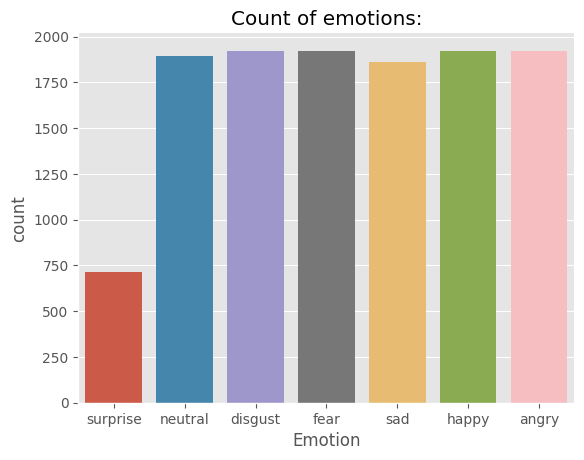

In [12]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

***Waveplot and Spectogram of Audio***

In [13]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term Fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

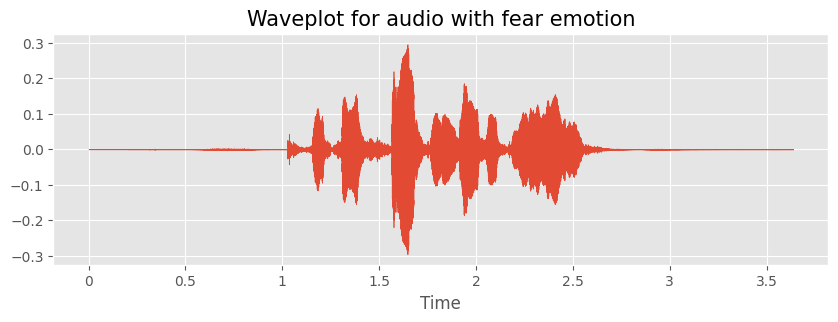

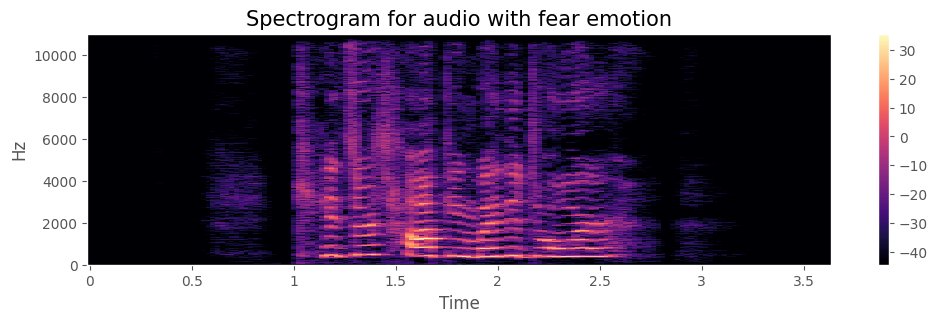

In [14]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

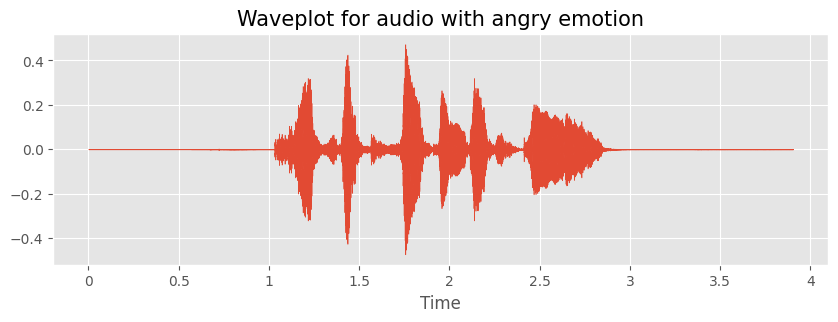

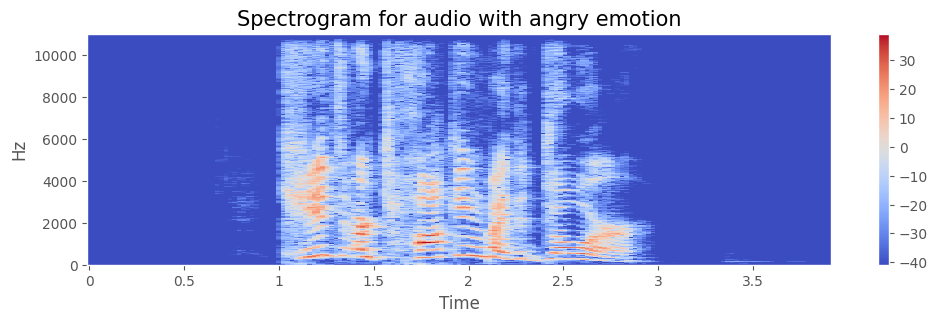

In [15]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

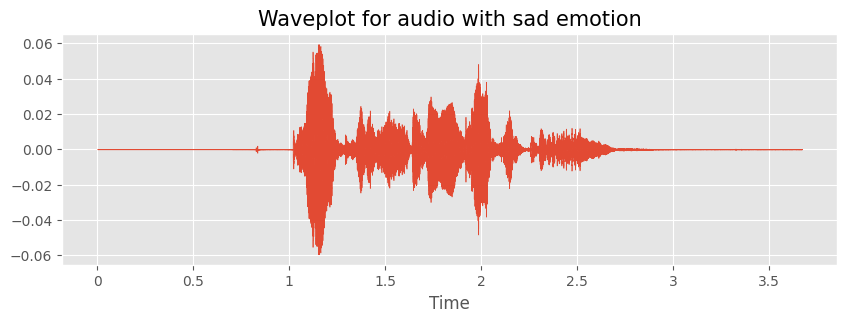

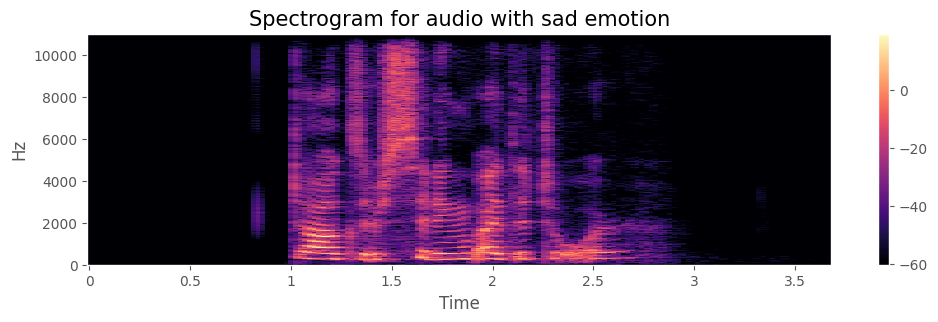

In [16]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# ***Data Augmentation***



We have some ways for data augmentation in sound data:

* Noise injection

* Stretching

* Shifting

* Pitching

In [17]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)




In [18]:
df.head()

Emotion                                               Path
0  surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   neutral  ../input/speech-emotion-recognition-en/Ravdess...

***Sample Path for testing***

In [19]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

***Simple Audio***

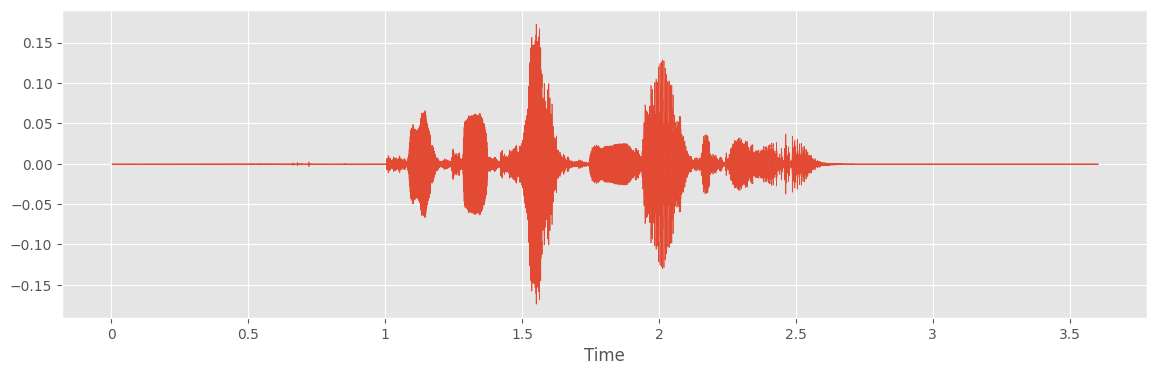

In [20]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sampling_rate)
Audio(path)

***1)Noised Audio***

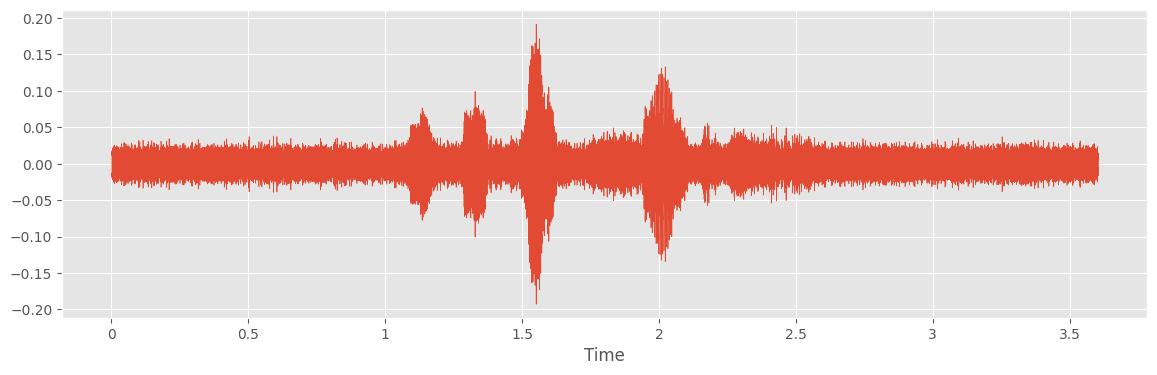

In [21]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)

***2)Stretch Audio***

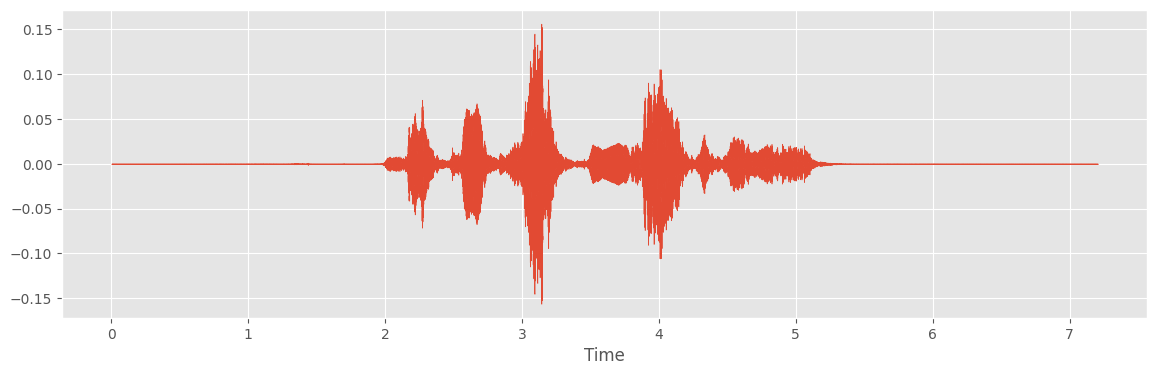

In [22]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

***3)Shifted Audio***

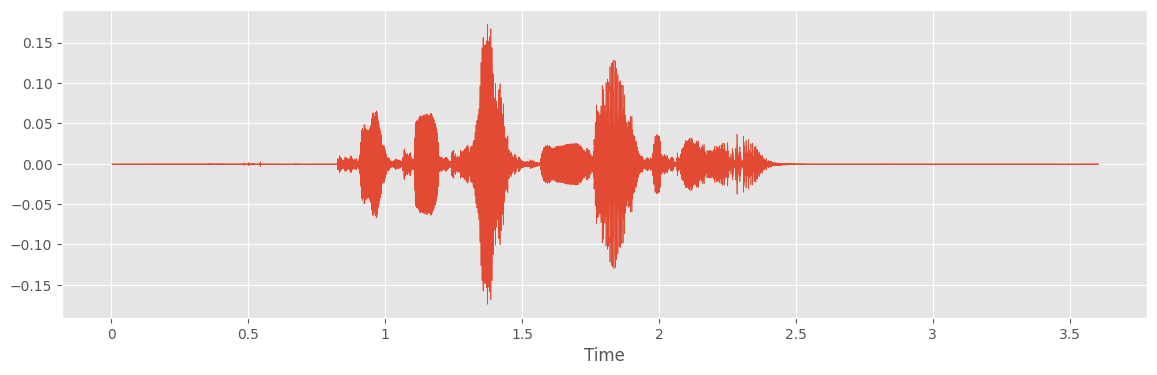

In [23]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)

***4)Pitched Audio***

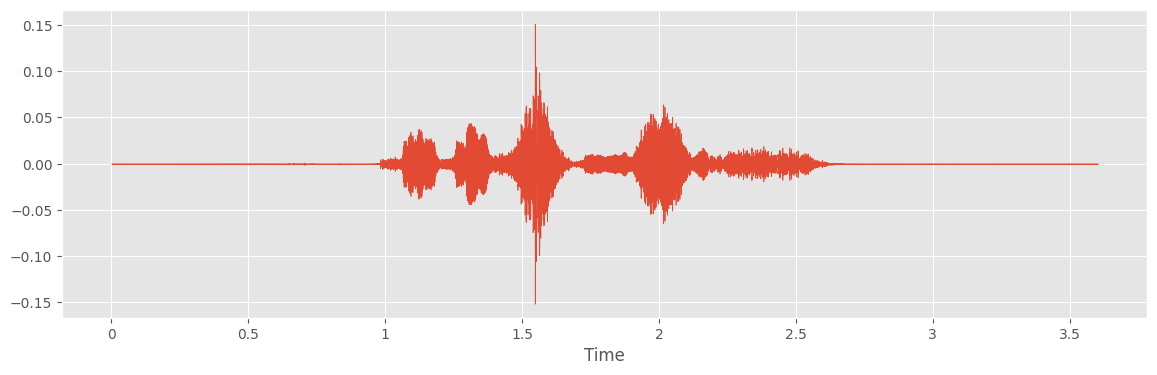

In [24]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

# ***Feature extraction***

There are some features may be useful:
* Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
* Energy : The sum of squares of the signal values, normalized by the respective frame length.
* Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
* Spectral Centroid : The center of gravity of the spectrum.
* Spectral Spread : The second central moment of the spectrum.
* Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
* Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
* Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
* MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [25]:
n_fft = 2048
hop_length = 512

In [26]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [27]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

55125

In [28]:
print("ZCR: ", zcr(data).shape)

print("RMS :", rmse(data).shape)

print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
RMS : (108,)
MFCC:  (2160,)


We decided to use just 2.5s duration with 0.6 offset - in the dataset first 0.6s contains no information about emotion, and most of them are less then 3s.



In [29]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        
                        rmse(data, frame_length, hop_length),
                        
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [30]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [31]:
X, Y = [], [] 
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 500 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
500 samples has been processed...
1000 samples has been processed...
1500 samples has been processed...
2000 samples has been processed...
2500 samples has been processed...
3000 samples has been processed...
3500 samples has been processed...
4000 samples has been processed...
4500 samples has been processed...
5000 samples has been processed...
5500 samples has been processed...
6000 samples has been processed...
6500 samples has been processed...
7000 samples has been processed...
7500 samples has been processed...
8000 samples has been processed...
8500 samples has been processed...
9000 samples has been processed...
9500 samples has been processed...
10000 samples has been processed...
10500 samples has been processed...
11000 samples has been processed...
11500 samples has been processed...
12000 samples has been processed...
Done.


In [32]:
features_path = "./features.csv"

In [33]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.245117  0.370117  0.490723  0.500000  0.494141  0.483887  0.493164   
2  0.303711  0.425293  0.527832  0.456543  0.374512  0.319336  0.278809   
3  0.265625  0.395508  0.505859  0.486816  0.451660  0.424316  0.415527   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.255371  0.251465  0.251953  ... -1.517690 -1.716483 -1.599310 -1.234609   
1  0.487305  0.498047  0.507812  ... -1.316412  0.260932 -2.746400 -2.503657   
2  0.257324  0.254395  0.254395  ... -1.393056 -1.010826 -0.445737  0.149898   
3  0.399414  0.400391  0.403809  ... -3.685813 -7.638473  1.644894  4.633826   
4  0.827637  0.835938  0.667969  ...  2.586417  2.746852  2.223276  0.986916   

       2371      2372      2373      2374      2375    labels  
0 -0.693198 -0.038982  0.675206  1.405603  2.112303  surprise  
1 -0.002069 -2.654631  0.696901  4.004205  3.131977  surprise  
2  0.653223  0.988896  1.136624  1.127551  1.030886  surprise  
3  2.444886  0.238787 -0.903094 -1.276556 -0.651460  surprise  
4 -0.730695 -2.530884 -4.002834 -4.849372 -4.929744   neutral  

[5 rows x 2377 columns]

In [34]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(48648, 2377)


In [35]:
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(48648, 2377)

In [36]:
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.245117  0.370117  0.490723  0.500000  0.494141  0.483887  0.493164   
2  0.303711  0.425293  0.527832  0.456543  0.374512  0.319336  0.278809   
3  0.265625  0.395508  0.505859  0.486816  0.451660  0.424316  0.415527   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.255371  0.251465  0.251953  ... -1.517690 -1.716483 -1.599310 -1.234609   
1  0.487305  0.498047  0.507812  ... -1.316412  0.260932 -2.746400 -2.503657   
2  0.257324  0.254395  0.254395  ... -1.393056 -1.010826 -0.445737  0.149898   
3  0.399414  0.400391  0.403809  ... -3.685813 -7.638473  1.644894  4.633826   
4  0.827637  0.835938  0.667969  ...  2.586417  2.746852  2.223276  0.986916   

       2371      2372      2373      2374      2375    labels  
0 -0.693198 -0.038982  0.675206  1.405603  2.112303  surprise  
1 -0.002069 -2.654631  0.696901  4.004205  3.131977  surprise  
2  0.653223  0.988896  1.136624  1.127551  1.030886  surprise  
3  2.444886  0.238787 -0.903094 -1.276556 -0.651460  surprise  
4 -0.730695 -2.530884 -4.002834 -4.849372 -4.929744   neutral  

[5 rows x 2377 columns]

In [37]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [38]:
lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38918, 2376), (9730, 2376), (38918, 7), (9730, 7))

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [41]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [42]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(35026, 2376, 1)

In [43]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [44]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [45]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc", f1_m])



In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [48]:
EPOCHS = 20
batch_size = 64

In [49]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping])

Epoch 1/20


I0000 00:00:1720570132.374021     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720570132.398263     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - acc: 0.3905 - f1_m: 0.2989 - loss: 1.8247

W0000 00:00:1720570253.635989     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720570255.175217     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


548/548 ━━━━━━━━━━━━━━━━━━━━ 163s 243ms/step - acc: 0.3906 - f1_m: 0.2990 - loss: 1.8240 - val_acc: 0.2806 - val_f1_m: 0.2541 - val_loss: 3.5582
Epoch 2/20


W0000 00:00:1720570265.566568     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - acc: 0.5721 - f1_m: 0.5229 - loss: 1.1223 - val_acc: 0.5349 - val_f1_m: 0.4962 - val_loss: 1.2619
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - acc: 0.6342 - f1_m: 0.6050 - loss: 0.9699 - val_acc: 0.5956 - val_f1_m: 0.5801 - val_loss: 1.0793
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - acc: 0.6941 - f1_m: 0.6771 - loss: 0.8105 - val_acc: 0.6344 - val_f1_m: 0.6147 - val_loss: 0.9871
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - acc: 0.7636 - f1_m: 0.7565 - loss: 0.6334 - val_acc: 0.6817 - val_f1_m: 0.6797 - val_loss: 0.9569
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 218ms/step - acc: 0.8312 - f1_m: 0.8280 - loss: 0.4703 - val_acc: 0.7127 - val_f1_m: 0.7115 - val_loss: 0.9284
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 218ms/step - acc: 0.8876 - f1_m: 0.8862 - loss: 0.3272 - val_acc: 0.7359 - val_f1_m: 0.7363 - val_loss: 0.7670
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - acc: 0.9212 - f1_

  7/305 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - acc: 0.9052 - f1_m: 0.8997 - loss: 0.3006

W0000 00:00:1720572306.878093     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


305/305 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - acc: 0.8990 - f1_m: 0.9000 - loss: 0.3447


W0000 00:00:1720572317.234410     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of our model on test data :  89.83556032180786 %


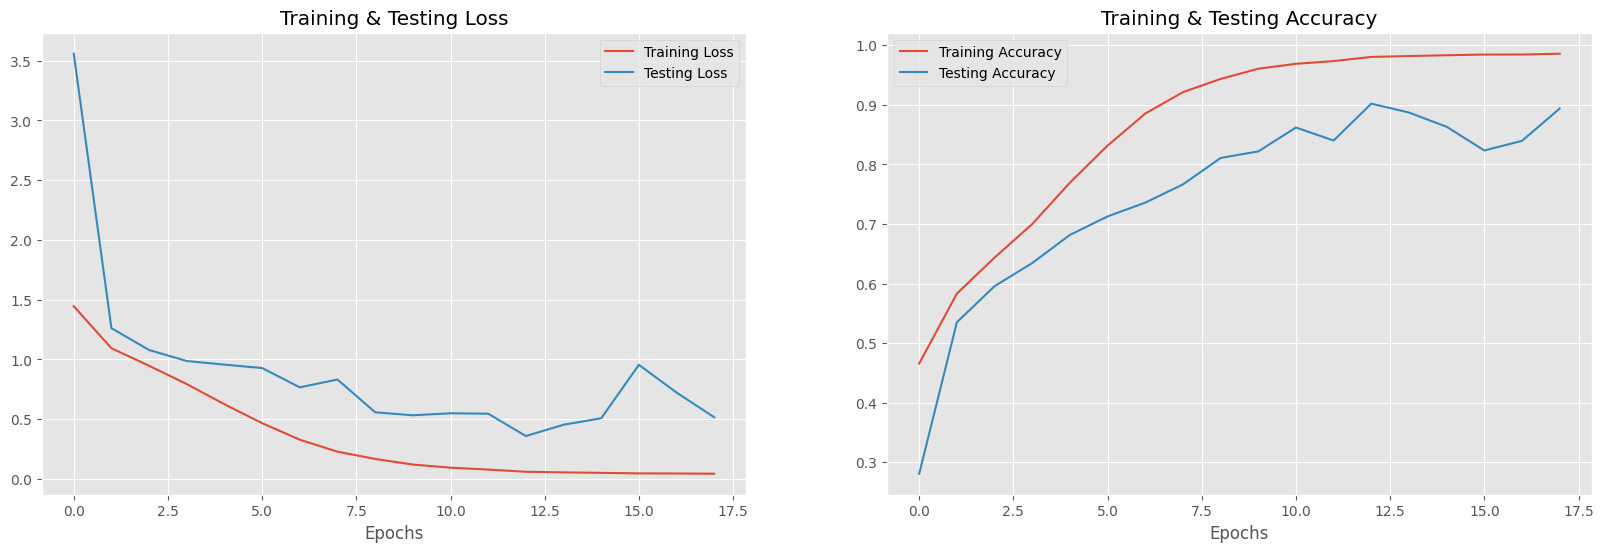

In [50]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [51]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

  6/305 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step  

W0000 00:00:1720572318.642419     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


W0000 00:00:1720572328.146730     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([0, 0, 1, ..., 4, 5, 2])

In [52]:
y_check = np.argmax(y_test, axis=1)
y_check

array([0, 0, 1, ..., 4, 5, 2])

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [54]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1356   40   35   41    7    1    4]
 [  37 1369   42   44   33   30    3]
 [  27   26 1331   50   26   37    8]
 [  46   24   67 1434   30   15    3]
 [  11   26   21   17 1454   27    2]
 [   1   45   37    5   61 1281    3]
 [   8    8   13   15   12    1  516]]


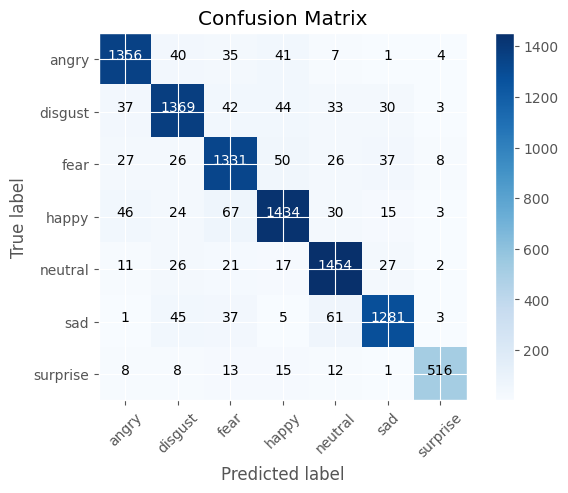

In [55]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [56]:
path_to_model = "./res_model.h5"

model.save(path_to_model)